<a href="https://colab.research.google.com/github/unica-ml/ml/blob/master/notebooks/ml06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elements of Linear Discriminant Functions

This is the notebook associated to Part 6 of the ML course.

Let's start by importing some utility functions.

In [0]:
from matplotlib import pyplot as plt
import numpy as np


def plot_function(fun, grid_limits=([0, 0], [1, 1]),
                  background=False, resolution=0.02, alpha=1.0, loop=False):
    """Plot function on 2D space."""
    x1_min, x1_max = grid_limits[0][0], grid_limits[1][0]
    x2_min, x2_max = grid_limits[0][1], grid_limits[1][1]
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    x = np.array([xx1.ravel(), xx2.ravel()]).T
    if loop:
        scores = np.zeros(shape=(x.shape[0],))
        for i in range(x.shape[0]):
            scores[i] = fun(x[i, :])
    else:
        scores = fun(x)
    Z = scores.reshape(xx1.shape)
    if background:  # plot decision function 
        plt.contourf(xx1, xx2, Z, cmap='jet', levels=50, alpha=alpha)
        plt.colorbar()
    else:
        # plot decision boundary
        plt.contourf(xx1, xx2, Z, levels=[-0.01, 0, 0.01], colors=('k',))
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    return

def plot_dataset(x, y, feat0=0, feat1=1):
    colors = ['r.', 'b.', 'g.', 'k.', 'c.', 'm.']
    class_labels = np.unique(y).astype(int)
    for k in class_labels:
        plt.plot(x[y == k, feat0], x[y == k, feat1], colors[k % 7])


Now let's code a simple class implementing a linear classifier $f(x)=w^T x + b$, and display its decision boundary on a bi-dimensional toy example.

Note that, if we set $h(x) = f(x) \cdot k$ (being $k$ a constant value), we obtain a linear classifier $h(x)$ with $w^\prime = kw$ and $b^\prime = kb$. While this classifier has the same decision boundary (in fact, $h(x)=0$ is equivalent to $f(x)=0$), it exhibits a different slope. For example, if $k>1$ the decision function will change more rapidly around each point $x$. You can compare the plots at the end of this section to note the difference.

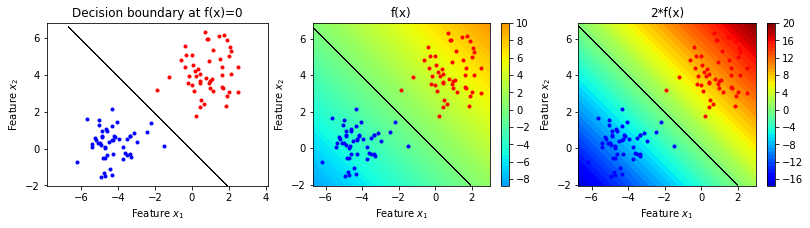

In [108]:
from sklearn.datasets import make_blobs


class LinearClassifier:
    """Simple class implementing f(x) = w'x +b."""

    def __init__(self, w, b):
        self.w = w
        self.b = b
    
    @property
    def w(self):
        return self._w
    
    @w.setter
    def w(self, w):
        self._w = np.array(w)

    @property
    def b(self):
        return self._b
    
    @b.setter
    def b(self, b):
        self._b = np.array(b)

    def decision_function(self, x):
        return x.dot(self.w)+b
    
    def predict(self, x):
        return np.array(self.decision_function(x) >= 0)
        

x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=3)

w = [1, 1]
b = 0.1

clf = LinearClassifier(w,b)

grid_limits = (x.min(axis=0)-0.5, x.max(axis=0)+0.5)

plt.figure(figsize=(13.5,3))
plt.subplot(1, 3, 1)
plot_dataset(x, y)
plot_function(clf.decision_function, background=False, grid_limits=grid_limits)
plt.axis('equal')
plt.title('Decision boundary at f(x)=0')
plt.xlabel(r'Feature $x_1$')
plt.ylabel(r'Feature $x_2$')

plt.subplot(1, 3, 2)
plot_dataset(x, y)
plot_function(clf.decision_function, background=True, grid_limits=grid_limits)
plt.clim([-20, 20])
plot_function(clf.decision_function, background=False, grid_limits=grid_limits)
plt.axis('equal')
plt.title('f(x)')
plt.xlabel(r'Feature $x_1$')
plt.ylabel(r'Feature $x_2$')

plt.subplot(1, 3, 3)
plot_dataset(x, y)
clf.w = 2*clf.w
clf.b = 2*clf.b
plot_function(clf.decision_function, background=True, grid_limits=grid_limits)
plt.clim([-20, 20])
plot_function(clf.decision_function, background=False, grid_limits=grid_limits)
plt.axis('equal')
plt.title('2*f(x)')
plt.xlabel(r'Feature $x_1$')
plt.ylabel(r'Feature $x_2$')

plt.show()

## Optimizing the Loss Function

We have described so far the basics of linear classification, namely, how samples are predicted by a linear classifier. 

The question that remains to be addressed is how one can learn the parameters $\theta = (w,b)$ for a linear classifier from the training data $D=(x_i, y_i)_{i=1}^n$.

This is typically achieved by formulating the learning problem as an optimization problem:

$$ \theta^\star \in \arg\min_\theta L(D, \theta),$$

where the objective function $L(D, \theta)$ is a proxy function to evaluating the classification error. This problem is typically solved efficiently via gradient descent.

Depending on the choice of the objective function $L(D, \theta)$, one can implement many different learning algorithms. Note that this formulation also holds for nonlinear classification functions and more complex algorithms, including neural networks and deep-learning algorithms.

Let's start from something easy. First of all, let's assume that the loss function can be decomposed as the sum of the loss on each training point: $L(D, \theta) = \frac{1}{n}\sum_{i=1}^n \ell(y_i, f(x_i; \theta))$. 

It is not difficult to see that, if we take $\ell$ to be 1 for correct predictions and 0 otherwise, $L$ will correspond to measuring the fraction of training points that are wrongly predicted (i.e., the training error). This is called the zero-one loss.

Below, we plot the zero-one loss along with the so-called hinge loss (i.e., its closest convex upper bound) as function of $y f(x)$. 
In fact, loss functions can be normally expressed as a function of the product $y f(x)$, given that, if $y f(x) \geq 0$, the point $x$ is correctly predicted ($y$ and $f$ agree in sign), otherwise it is misclassified.

Here are the equations: 
- zero-one loss: $\ell(y, f(x)) = \begin{cases} 1, \; {\rm if} \; yf(x) < 0, \\ 0, \; {\rm otherwise.}\end{cases}$.
- hinge loss: $\ell(y, f(x)) = \max(0, 1-yf(x))$.




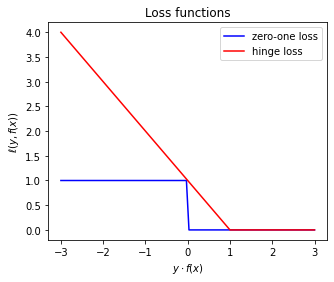

In [109]:
yf = np.linspace(-3, 3, num=100)
hinge = 1-yf
hinge[hinge<=0]=0
zero_one = yf < 0

plt.figure(figsize=(5,4))
plt.plot(yf, zero_one, 'b', label='zero-one loss')
plt.plot(yf, hinge, 'r', label='hinge loss')
plt.xlabel(r'$y \cdot f(x)$')
plt.ylabel(r'$\ell(y, f(x))$')
plt.title('Loss functions')
plt.legend()
plt.show()



Let's have a look at how these losses behave in the space of parameters $(w_1, w_2)$, assuming that $b=0$ (not optimized).

Every point in this space is a linear classifier (i.e., a hyperplane passing through the origin) and we report (using the color axis) the corresponding error on the training set (i.e., the training loss).

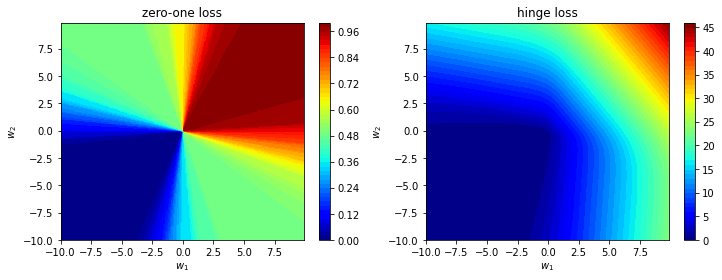

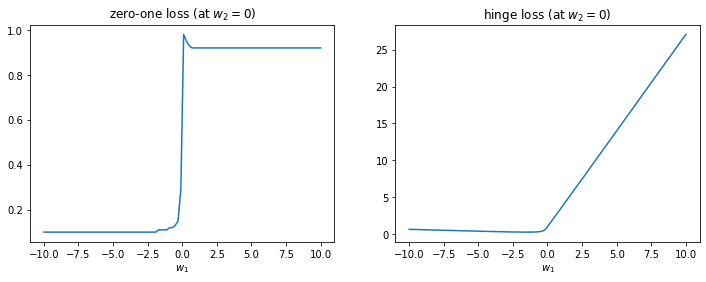

In [110]:
class Loss:
    """Class implementing basic loss functions."""
    def __init__(self, clf, x, y):
        self._clf = clf  # classifier to be evaluated
        self._x = x  # training points
        self._y = y  # training labels

    def zero_one_loss(self, w=None):
        if w is not None:
            self._clf.w = w
        y = 2*self._y - 1  # convert {0,1} to {-1,+1}
        scores = self._clf.decision_function(self._x)
        return np.mean(y*scores < 0)
    
    def hinge_loss(self, w=None):
        if w is not None:
            self._clf.w = w
        y = 2*self._y - 1  # convert {0,1} to {-1,+1}
        scores = self._clf.decision_function(self._x)
        hinge = 1-y*scores
        hinge[hinge <= 0] = 0
        return np.mean(hinge)


clf = LinearClassifier(w=[1, 1],b=0)
loss = Loss(clf, x, y)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_function(loss.zero_one_loss, background=True, 
              loop=True, resolution=0.1,
              grid_limits=([-10,-10], [10, 10]))
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.title('zero-one loss')

plt.subplot(1, 2, 2)
plot_function(loss.hinge_loss, background=True, 
              loop=True, resolution=0.1,
              grid_limits=([-10,-10], [10, 10]))
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.title('hinge loss')
plt.show()

# we now fix w2=0 and let only w1 change
n_points=100
w1 = np.linspace(-10, 10, num=n_points)
w2 = np.zeros(shape=(n_points,))
w = np.vstack((w1,w2)).T
zero_one = np.zeros(shape=(n_points,))
hinge = np.zeros(shape=(n_points,))
for i in range(n_points):
    zero_one[i] = loss.zero_one_loss(w[i, :])
    hinge[i] = loss.hinge_loss(w[i, :])

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(w1, zero_one)
plt.xlabel(r'$w_1$')
plt.title(r'zero-one loss (at $w_2=0$)')

plt.subplot(1, 2, 2)
plt.plot(w1, hinge)
plt.xlabel(r'$w_1$')
plt.title(r'hinge loss (at $w_2=0$)')
plt.show()



Let's extend our class now by adding the derivative of the hinge, and let's run gradient descent to optimize the loss.

The hinge loss $\ell(y, f(x)) = \max(0, 1-yf(x))$ is not differentiable at the hinge, i.e., when $yf(x)=1$, but subgradients can be used. 
In this case, we can assume that the gradient is zero at the hinge. Accordingly, we can set the gradient to zero when the loss is zero, and instead differentiate $1-yf(x)$ w.r.t. $w$ when the hinge loss is not null. We thus get:

$$\nabla_w \ell(y, f(x))=\begin{cases} 0, \; {\rm if} \; 1-yf(x) \leq 0, \\ -yx, \; {\rm otherwise.}\end{cases}$$

We also report the derivative w.r.t. $b$ for completeness:

$$\nabla_b \ell(y, f(x))=\begin{cases} 0, \; {\rm if} \; 1-yf(x) \leq 0, \\ -y, \; {\rm otherwise.}\end{cases}$$

Recall that these are derivatives of the loss computed for each training point. We will then need to average these values over all training points.


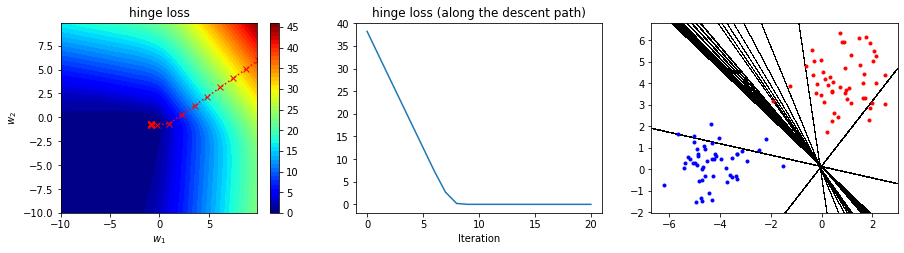

In [111]:
class LossGrad(Loss):
    """Extend previous class by adding the hinge loss gradient."""

    def __init__(self, clf, x, y):
        Loss.__init__(self, clf, x, y)

    def hinge_loss_gradient(self, w=None):
        if w is not None:
            self._clf.w = w
        y = 2*self._y - 1  # convert {0,1} to {-1,+1}
        scores = self._clf.decision_function(self._x)
        hinge = 1-y*scores
        hinge[hinge <= 0] = 0
        grad = np.zeros(shape=self._x.shape)  # one grad per point
        grad[hinge > 0, :] =  self._x[hinge>0, :]
        y = np.atleast_2d(y)  # required to broadcast (on each column of grad)
        grad *= -y.T
        return np.mean(grad, axis=0)


# let's start optimizing. We start from w=[10,6]
n_iter = 20
w = np.zeros(shape=(n_iter+1, 2))
hinge = np.zeros(shape=(n_iter+1, ))  # objective at w in each iter

w[0, :] = np.array([10., 6.])  # init
clf = LinearClassifier(w=w[0, :], b=0)
loss = LossGrad(clf, x, y)

hinge[0] = loss.hinge_loss(w=clf.w)

eta = 0.5  # gradient step size
for i in range(n_iter):
    clf.w -= eta * loss.hinge_loss_gradient(w=clf.w)
    w[i+1, :] = clf.w
    hinge[i+1] = loss.hinge_loss(w=clf.w)

plt.figure(figsize=(15,3.5))

plt.subplot(1, 3, 1)
plot_function(loss.hinge_loss, background=True, 
              loop=True, resolution=0.1,
              grid_limits=([-10,-10], [10, 10]))
plt.plot(w[:, 0], w[:, 1], 'rx:')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.title('hinge loss')

plt.subplot(1, 3, 2)
plt.plot(hinge)
plt.xlabel('Iteration')
plt.title('hinge loss (along the descent path)')

plt.subplot(1, 3, 3)
plot_dataset(x, y)
for i in range(n_iter+1):
    clf.w = w[i, :]
    plot_function(clf.decision_function, grid_limits=grid_limits)

plt.show()